The first step here is to add MRNs to NISC IDs, and then add in the phenotypes Jen compiled for the PRS paper. But it's possible that someone had WES but not genotypes. So, let's see how many people kids we have WES, but no compiled pheno.

In [8]:
%%bash

cd ~/data/cnv
grep -f kid_samples.txt nisc_to_mrn.txt | cut -f 2 > mrns.txt;
rm no_dti.txt no_struct.txt no_neuropsych.txt;
while read mrn; do
    if ! grep -q $mrn dti_07062017.csv; then
        echo $mrn >> no_dti.txt
    fi
    if ! grep -q $mrn struct_08042017.csv; then
        echo $mrn >> no_struct.txt
    fi
    if ! grep -q $mrn neuropsych_09062017.csv; then
        echo $mrn >> no_neuropsych.txt
    fi
done < mrns.txt;
wc -l no_neuropsych.txt
wc -l no_dti.txt
wc -l no_struct.txt

24 no_neuropsych.txt
26 no_dti.txt
25 no_struct.txt


OK, this is correct... but there's gotta be something wrong, as half of the 51 kids don't seem to have at least one type of data. But even after checking in Labmatrix, I have 23 kids without mprages, 22 don't have DTI. But I did find 16 out of the 24 without neuropsych (at least for WISC).

All in all, it looks like we only have 29 kids with DTI, and 28 with MPRAGE (and that's without even taking QCinto consideration). Not great. We might still be able to do something here, but the contrasts with unaffected subling with be quite sparse. Maybe we could go slowly, just adding phenotypes to the matrix slowly. Like, start with SX which everyone should have, then some neuropsych slowly, etc. **The plots would report the N for each computation, especially when we look only at the differences! **

Jen is compiling the data. Let's work on the scripts while that's going on.

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)
%matplotlib inline

In [10]:
# figure out who is who in each trio
import glob
ped_file = '/data/sudregp/cnv/simplex.ped'
wes_prefix = ['CLIA', 'CCGO', 'WPS']
trios = []
affected = []
controls = []
samples = []
famids = []
fid = open(ped_file, 'r')
for line in fid:
    famid, sid, fa, mo, sex, aff = line.rstrip().split('\t')
    if fa[:4] in wes_prefix and mo[:4] in wes_prefix and sid[:4] in wes_prefix:
        fam = {}
        fam['child'] = sid
        if aff == '1':
            affected.append(sid)
        else:
            controls.append(sid)
        fam['father'] = fa
        fam['mother'] = mo
        fam['famid'] = famid
        trios.append(fam)
        samples += [sid, fa, mo]
        famids.append(famid)
fid.close()
samples = set(samples)
famids = set(famids)

fid = open('/data/sudregp/cnv/kid_samples.txt', 'r')
good_kids = [line.rstrip() for line in fid]
fid.close()

In [83]:
# merge kid info with phenotype
pheno_fname = '/home/sudregp/data/cnv/neuropsych_09062017.csv'
df1 = pd.read_table('/home/sudregp/data/cnv/nisc_to_mrn.txt')
df2 = pd.read_csv(pheno_fname)

pcorrs = []
scorrs = []
titles = []
data_dir = '/home/sudregp/data/cnv/xhmm/'
files = glob.glob(data_dir + '/denovo_q60*cnv.indiv')
for f in files:
    # open PLINK file and grab the burden for all kids
    df = pd.read_table(f, delimiter='\s+', index_col=1)
    kids = [t['child'] for t in trios]
    ncnv = []
    for kid in kids:
        idx = [i for i in range(df.shape[0]) if df.index[i].find(kid) >= 0][0]
        ncnv.append(int(df.iloc[idx]['NSEG']))
    df3 = pd.DataFrame(ncnv, index=kids, columns=['ncnv'])
    data = pd.merge(df1, df2, left_on='ID', right_on='MRN')
    data = pd.merge(data, df3, left_on='code', right_index=True)
    ans = data.corr()['ncnv'][2:-1]
    # save the result if it's not NaN all across the board
    if not np.isnan(ans).all():
        pcorrs.append(ans)
        scorrs.append(data.corr(method='spearman')['ncnv'][2:-1])
        t_str = '.'.join(f.split('/')[-1].split('.')[:-2])
        titles.append(t_str)


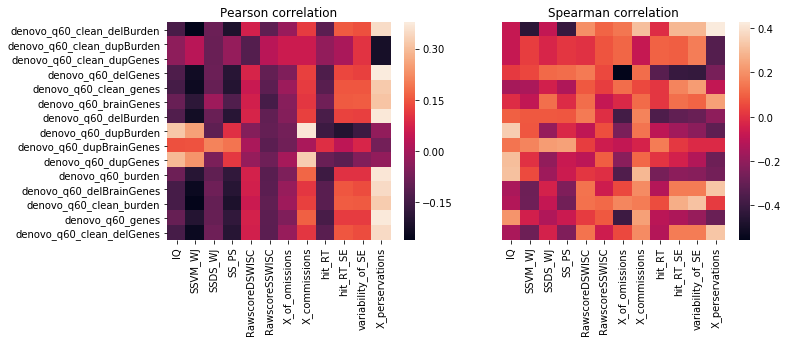

In [84]:
plt.figure(figsize=(11,4))
plt.subplot(1,2,1)
sns.heatmap(pd.DataFrame(pcorrs, index=titles))
plt.title('Pearson correlation')
plt.subplot(1,2,2)
sns.heatmap(pd.DataFrame(scorrs, index=titles), yticklabels=False)
plt.title('Spearman correlation')